In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression, PLSSVD

In [2]:
#Bu çalışmada veri seti üzerinde Kısmi en küçük kareler(Partial Least Squares) regresyon modelini kullanacağız.
#PLS; bileşenleri bağımsız değişkenlerin çıktı değişkeniyle kovaryansını maksimumda tutacak şekilde oluşturur.
#PCR ile PLS benzerdir.#PCR gözetimsiz, PLS gözetimli boyun indirgeme diyebiliriz.
#Veri ön işleme aşamaları.
data=pd.read_csv("Hitters.csv")
df=data.copy()
df=df.dropna()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
y=df[["Salary"]]
dms=pd.get_dummies(df[["League","Division","NewLeague"]])
x=df.drop(["Salary","League","Division","NewLeague"],axis=1).astype("float64")
x=pd.concat([x,dms[["League_N","Division_W","NewLeague_N"]]],axis=1)
x.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [6]:
#PLS i kulanarak modelimizi kuralım.
#n_components=bileşen sayısı ; Parametreyi kullanmazsak default tanımlı 2 bileşenli oluşturuyor.
pls_model=PLSRegression().fit(x_train,y_train)

In [10]:
#Kaç bileşen kullandığını görelim.
pls_model.n_components

2

In [9]:
#Modelin oluşturduğu katsayılar.
#Tahmin için bir gözlem geldiğinde 2 değişkenli olarak gelmez.Veri setinde kaç değişken var ise o kadar değişkenli gelir.
#Bu yüzden modeli 2 bileşenli olarak kuruyor fakat yine de her değişkenin katsayısı oluyor.
pls_model.coef_

array([[ 35.32916493],
       [ 48.83425857],
       [ 18.50240933],
       [ 39.28117603],
       [ 30.59952998],
       [ 40.03398345],
       [ 16.85990516],
       [ 28.22289896],
       [ 32.73784993],
       [ 22.00875744],
       [ 33.60903032],
       [ 30.39402522],
       [ 25.73279799],
       [ 54.98835148],
       [  6.56590871],
       [ -0.90894359],
       [ 17.60903423],
       [-37.24246339],
       [ 14.69680385]])

In [11]:
y_pred=pls_model.predict(x_test)

In [12]:
y_test.head()

,Salary
148,850.0
154,277.5
318,875.0
279,150.0
88,260.0


In [13]:
y_pred[:10]

array([[616.22393849],
       [751.6096804 ],
       [945.50187006],
       [444.49531428],
       [462.83034764],
       [324.65918467],
       [664.78634485],
       [477.63352911],
       [959.31718189],
       [579.63067892]])

In [17]:
"Test hatası: ",np.sqrt(mean_squared_error(y_test,y_pred))

('Test hatası: ', 398.09956327448526)

In [18]:
r2_score(y_test,y_pred)

0.2678940112232917

In [23]:
#Model tuning bölümüne geçelim.
#Sonuçların daha anlamlı olması için 10 katlı cross validation kuralım.
#Hata kareler ortaması kare kökü değerlerini atmak için bir liste oluşturalım.
cv_10=model_selection.KFold(n_splits=10,shuffle=True,random_state=66)
RMSE=[]

In [24]:
#Modelin her bir bileşen sayısı için cross validation yöntemiyle hesaplanan skorları listemize atalım. 
for i in np.arange(1,x_train.shape[1]+1):
    pls=PLSRegression(n_components=i)
    score=np.sqrt(-1*cross_val_score(pls,x_train,y_train,cv=cv_10,scoring="neg_mean_squared_error").mean())
    RMSE.append(score)


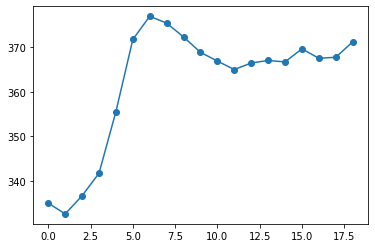

In [25]:
#Her bileşen için oluşan hataları grafikte görelim.
#En az hata 2 bileşen ile oluşan modelde çıkıyormu.
plt.plot(RMSE,"-o");

In [26]:
#Modeli 2 bileşenli olarak tekrar kuralım.
pls_model=PLSRegression(n_components=2).fit(x_train,y_train)

In [27]:
y_test_pred=pls_model.predict(x_test)

In [30]:
y_test[:5]

,Salary
148,850.0
154,277.5
318,875.0
279,150.0
88,260.0


In [34]:
y_test_pred[:5]

array([[616.22393849],
       [751.6096804 ],
       [945.50187006],
       [444.49531428],
       [462.83034764]])

In [36]:
#Gerçek ve tahmin değerlerini görselleştirmek için tahmin değerlerini indexleyelim.
df_pred=pd.DataFrame(y_test_pred,columns=['Salary'],index=y_test.index)
df_pred.head()

,Salary
148,616.223938
154,751.609680
318,945.501870
279,444.495314
88,462.830348


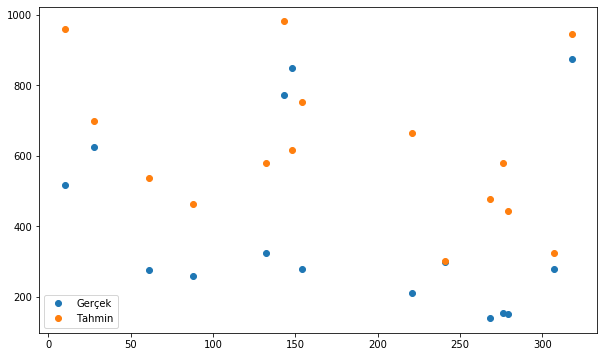

In [40]:
plt.figure(figsize=(10,6))
plt.plot(y_test.head(15),"o")
plt.plot(df_pred.head(15),"o")
plt.legend(["Gerçek","Tahmin"]);